# Imports

In [5]:
import pandas as pd
import numpy as np
import data_processing_pipeline
import project_metrics
import matplotlib.pyplot as plt


from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

#need to import a scoring metric here
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

# Functions

# Data + Pre-Processing

## Builders

In [2]:
base_df = data_processing_pipeline.run_base_df()

base_df.head()

/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/data_processing_pipeline.py:40: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method="linear")


Training


/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/data_processing_pipeline.py:58: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method="linear")


,date,store_nbr,family,sales,onpromotion,city,state,store_type,store_cluster,transactions,dol_per_barrel,holiday_type,locale,locale_name,holiday_description,transferred,rolling_30day_avg_traffic,rolling_15day_avg_traffic
0,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False,770.0,770.0
1,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False,770.0,770.0
2,2013-01-01,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False,770.0,770.0
3,2013-01-01,25,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False,770.0,770.0
4,2013-01-01,25,BOOKS,0.0,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False,770.0,770.0


NOTES ABOUT THE CLEANING

## Scoring

Mean Anbolute Scaled Error (MASE) is a scoring metric good for our timeseries data and forecasting approaches as it ratios the Mean Absolute Error (MAE) of a model against its naively assumed MAE (called this $\text{MAE}_\alpha$). Thus the resulting equation for MASE is as follows:

$$
\text{MASE} = \frac{\text{MAE}}{\text{MAE}_\alpha}
$$

We focus first on a naive MAE which is computed based on naive forecasting. Naive forecasting is is a simplistic approach towards forecasting which makes the assumption that a future value remain mostly unchanged from the last previous value - ergo it does not take into account exogenous conditions and featuress that may influence the trend of a value over time. Naive forecasting is done often for establishing a benchmark or baseline.

For the purpose of this project, we are going to construct our own function that we can use for measuring the MASE of our predictions. 

We start with showcasing the formula for the naive MAE, $\text{MAE}_\alpha$. This specific formula looks over an entire duration of timesteps...

$$
\text{MAE}_\alpha = \frac{1}{N-1} \sum_{i = 2}^{N} \text{abs}(y_i - y_{i-1})
$$

Now if we incorporate a seasonal variation from the forecast, we would then equate the forecast to an actual value from the period, but from the previous season corresponding to the current period (i.e. this year vs last year)...

Thus we have:

$$
\text{MAE}_\alpha = \frac{1}{N-m} \sum_{i = m+1}^{N} \text{abs}(y_i - y_{i-m})
$$

Above we cover the MAE for the naive forecast. To continue building our MASE metric, we would also leverage an MAE on our new algorithm meant to construct predictions (call then $o_n$$)

Therefore:

$$
\text{MAE} = \frac{1}{N}\sum_{j=1}^{N} \text{abs}(o_i - y_i)
$$


Finally, the MASE is then constructured from these error metrics as:


$$
\text{MASE} = \frac{\text{MAE}}{\text{MAE}_\alpha}
$$

As a ratio, MASE is measured around the value of 1. When the MAE from our model performs better than the MAE of the naive assumption, the MASE ratio goes below the value of 1. Above the value of one indicates our model's error is much stronger than the naive error, indicating the model performs very poorly. 


Sources: https://medium.com/@ashishdce/mean-absolute-scaled-error-mase-in-forecasting-8f3aecc21968

Sources: https://www.launchfulfillment.com/inventory-management-naive-forecasting/

# SARIMAX Re-attempt

In [3]:
first_n_dates=30
last_n_dates=15 #30 days visually adhere's well

X_train, y_train, X_test, y_test = data_processing_pipeline.antiquated_single_model_pre_process(base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/data_processing_pipeline.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/data_processing_pipeline.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date"] = pd.to_datetime(base_df["date"]) #redundancy due to bug?
/Users/chriskuzemka/Docu

In [8]:
X_train

,dol_per_barrel,rolling_15day_avg_traffic,rolling_30day_avg_traffic,store_nbr,day_of_week_sine,day_of_week_cosine,family_GROCERY I,city_Quito,state_Pichincha,store_type_A,...,holiday_description_Traslado Batalla de Pichincha,holiday_description_Traslado Fundacion de Guayaquil,holiday_description_Traslado Independencia de Guayaquil,holiday_description_Traslado Primer Grito de Independencia,holiday_description_Traslado Primer dia del ano,holiday_description_Viernes Santo,holiday_description_nan,transferred_False,transferred_True,transferred_nan
date_index,,,,,,,,,,,,,,,,,,,,,
2013-02-01,97.460000,3299.666667,3361.933333,45.0,-7.818315e-01,0.623490,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2013-02-02,97.006427,3370.666667,3395.733333,45.0,-2.449294e-16,1.000000,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2013-02-03,96.381633,3384.933333,3414.666667,45.0,7.818315e-01,0.623490,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2013-02-04,96.210000,3327.333333,3380.466667,45.0,9.749279e-01,-0.222521,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2013-02-05,96.680000,3335.266667,3341.633333,45.0,4.338837e-01,-0.900969,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-27,49.050000,3764.933333,3830.700000,45.0,-9.749279e-01,-0.222521,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2017-07-28,49.720000,3825.933333,3856.833333,45.0,-7.818315e-01,0.623490,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2017-07-29,49.898682,3865.000000,3903.966667,45.0,-2.449294e-16,1.000000,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Above we confirm that with nans set to 0, this has introduced a several crashes into our dataset. We will use a ffill on the nans instead, which will make a naive assumption for interpolation on the nans. In this case, the `dol_per_barrel` will assume a previous timestep price and replace the gaps with such value. 

In [21]:
base_df[
    (base_df["store_nbr"] == 45) &
    (base_df["family"] == "GROCERY I")
][["store_nbr", "city", "state", "store_type"]].value_counts()

store_nbr  city   state      store_type
45         Quito  Pichincha  A             1707
Name: count, dtype: int64

Furthermore, note the counts of redundant named column value pairings. We will remove such columns.

In [6]:
# Basic model setup
model = SARIMAX(
    y_train,                     # Target variable
    order=(1, 0, 2),                    # Default ARIMA order
    seasonal_order=(1, 0, 2, 7),        # Default seasonal order (no seasonality)
    exog=X_train        # Optional: Exogenous variables
)
model_fit = model.fit(disp=False)

forecast = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

y_test_clipped = np.maximum(y_test, 0)
forecast_clipped = np.maximum(forecast, 0)

/Users/chriskuzemka/anaconda3/envs/base_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


NameError: name 'rmsle' is not defined

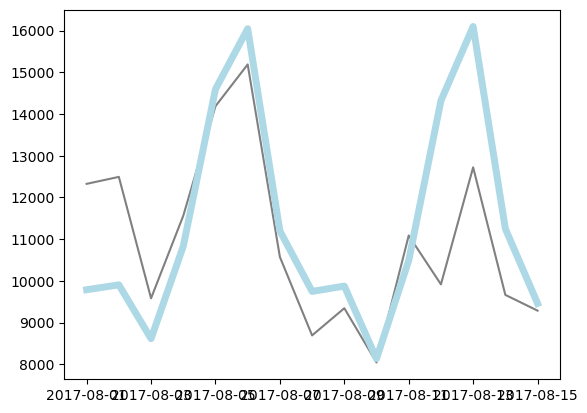

In [7]:
VALUE_COLORS = {
    "y_pred":"blue",
    "y_test":"gray",
    "y_train":"lightblue"
}


plt.plot(y_test_clipped.index, y_test_clipped, color="gray", label="Actual Testing Values")
plt.plot(forecast_clipped.index, forecast_clipped, color="lightblue", label="Predicted Testing Values", linewidth=5)

plt.title(f"STORE 45: GROCERY I \n Sales Prediciton Comparison to Actual \n [{last_n_dates} day Forecast (RMSLE: {rmsle.round(2)}; RMSE: {rmse.round(2)}) \n (Baseline Mean: {target_mean.round(2)}; Mean Percentage Error: {rmse_percentage.round(2)}%) ]", fontweight="bold", size=15)
plt.xlabel("Time", size=15)
plt.ylabel("Total Sales", size=15)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)


plt.grid(which="major")
plt.legend()
plt.tight_layout()

plt.savefig(f"../images/{last_n_dates}_day_model.png", format="png", dpi=300)

## Old Problem and Re-execution

## Model Packaging and Deployment onto Other Categories